In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from datasets import load_dataset
from timm import create_model
from transformers import ViTImageProcessor
from transformers import ViTConfig, ViTModel
import evaluate 
import numpy as np

In [21]:
from transformers import ViTImageProcessor

model_name_or_path = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTImageProcessor.from_pretrained(model_name_or_path, return_tensors='pt')

In [22]:
# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

In [23]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

In [24]:
ds = load_dataset("C:/Thesis/Dataset4classes2", num_proc=3)


Resolving data files:   0%|          | 0/45388 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/600 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1150 [00:00<?, ?it/s]

In [25]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 45388
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1150
    })
})


In [26]:
dataset_train = ds['train']
dataset_valid = ds['validation']
num_classes = len(set(dataset_train['label']))
labels = ds['train'].features['label']
print(num_classes, labels)

4 ClassLabel(names=['bcc', 'mel', 'others', 'scc'], id=None)


In [27]:
example = feature_extractor(dataset_train[0]['image'], return_tensors = 'pt')

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
def preprocess(batch):
    inputs = feature_extractor(batch['image'], return_tensors='pt').to(device)
    inputs['label'] = batch['label']
    return inputs

In [30]:
prepared_train = dataset_train.with_transform(preprocess)
prepared_valid = dataset_valid.with_transform(preprocess)

In [31]:
print(prepared_train.features)

{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['bcc', 'mel', 'others', 'scc'], id=None)}


In [32]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [33]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
metric = evaluate.load("accuracy")

Using the latest cached version of the module from C:\Users\abadd\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Dec  6 16:58:05 2024) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.


In [35]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [36]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir='resultsbase4c', 
    per_device_eval_batch_size=12,
    eval_strategy="steps",
    num_train_epochs=5,
    gradient_accumulation_steps=4,
    save_steps=500,
    eval_steps=500,
    logging_steps=10,
    learning_rate=2e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    dataloader_pin_memory=False,
    fp16=True
    )

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= prepared_train,
    eval_dataset= prepared_valid,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    tokenizer=feature_extractor
)

C:\Users\abadd\AppData\Local\Temp\ipykernel_27632\2735172214.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [38]:
results = trainer.train()

  0%|          | 0/7090 [00:00<?, ?it/s]

{'loss': 1.3695, 'grad_norm': 4.337615966796875, 'learning_rate': 1.997179125528914e-05, 'epoch': 0.01}
{'loss': 1.3308, 'grad_norm': 4.955028533935547, 'learning_rate': 1.994358251057828e-05, 'epoch': 0.01}
{'loss': 1.2873, 'grad_norm': 5.138838768005371, 'learning_rate': 1.991537376586742e-05, 'epoch': 0.02}
{'loss': 1.2376, 'grad_norm': 4.704006195068359, 'learning_rate': 1.988716502115656e-05, 'epoch': 0.03}
{'loss': 1.2078, 'grad_norm': 6.315433979034424, 'learning_rate': 1.98589562764457e-05, 'epoch': 0.04}
{'loss': 1.1438, 'grad_norm': 5.738340377807617, 'learning_rate': 1.983074753173484e-05, 'epoch': 0.04}
{'loss': 1.1262, 'grad_norm': 7.075477123260498, 'learning_rate': 1.980253878702398e-05, 'epoch': 0.05}
{'loss': 1.0582, 'grad_norm': 5.751842021942139, 'learning_rate': 1.9774330042313118e-05, 'epoch': 0.06}
{'loss': 1.0757, 'grad_norm': 7.02844762802124, 'learning_rate': 1.974612129760226e-05, 'epoch': 0.06}
{'loss': 1.0496, 'grad_norm': 9.727574348449707, 'learning_rate':

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.9693005084991455, 'eval_accuracy': 0.5883333333333334, 'eval_runtime': 63.8129, 'eval_samples_per_second': 9.402, 'eval_steps_per_second': 0.784, 'epoch': 0.35}
{'loss': 0.6891, 'grad_norm': 13.478370666503906, 'learning_rate': 1.8561354019746123e-05, 'epoch': 0.36}
{'loss': 0.638, 'grad_norm': 20.209972381591797, 'learning_rate': 1.8533145275035264e-05, 'epoch': 0.37}
{'loss': 0.6733, 'grad_norm': 16.858558654785156, 'learning_rate': 1.8504936530324402e-05, 'epoch': 0.37}
{'loss': 0.6899, 'grad_norm': 18.010610580444336, 'learning_rate': 1.847672778561354e-05, 'epoch': 0.38}
{'loss': 0.6699, 'grad_norm': 21.225370407104492, 'learning_rate': 1.8448519040902682e-05, 'epoch': 0.39}
{'loss': 0.6632, 'grad_norm': 17.429399490356445, 'learning_rate': 1.842031029619182e-05, 'epoch': 0.39}
{'loss': 0.6487, 'grad_norm': 17.658828735351562, 'learning_rate': 1.8392101551480962e-05, 'epoch': 0.4}
{'loss': 0.6694, 'grad_norm': 16.67638397216797, 'learning_rate': 1.83638928067701e-0

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.9173696041107178, 'eval_accuracy': 0.655, 'eval_runtime': 65.8331, 'eval_samples_per_second': 9.114, 'eval_steps_per_second': 0.759, 'epoch': 0.7}
{'loss': 0.5682, 'grad_norm': 12.58913803100586, 'learning_rate': 1.7150916784203105e-05, 'epoch': 0.71}
{'loss': 0.5273, 'grad_norm': 32.025970458984375, 'learning_rate': 1.7122708039492243e-05, 'epoch': 0.72}
{'loss': 0.541, 'grad_norm': 12.401185989379883, 'learning_rate': 1.7094499294781385e-05, 'epoch': 0.73}
{'loss': 0.4569, 'grad_norm': 17.922636032104492, 'learning_rate': 1.7066290550070523e-05, 'epoch': 0.73}
{'loss': 0.5206, 'grad_norm': 17.821718215942383, 'learning_rate': 1.703808180535966e-05, 'epoch': 0.74}
{'loss': 0.5066, 'grad_norm': 12.989253044128418, 'learning_rate': 1.7009873060648803e-05, 'epoch': 0.75}
{'loss': 0.5081, 'grad_norm': 24.668367385864258, 'learning_rate': 1.698166431593794e-05, 'epoch': 0.75}
{'loss': 0.6086, 'grad_norm': 33.337318420410156, 'learning_rate': 1.6953455571227083e-05, 'epoch':

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.0926177501678467, 'eval_accuracy': 0.6283333333333333, 'eval_runtime': 65.894, 'eval_samples_per_second': 9.106, 'eval_steps_per_second': 0.759, 'epoch': 1.06}
{'loss': 0.394, 'grad_norm': 11.00757884979248, 'learning_rate': 1.574330042313117e-05, 'epoch': 1.06}
{'loss': 0.3758, 'grad_norm': 41.30321502685547, 'learning_rate': 1.5715091678420312e-05, 'epoch': 1.07}
{'loss': 0.3675, 'grad_norm': 14.965021133422852, 'learning_rate': 1.568688293370945e-05, 'epoch': 1.08}
{'loss': 0.3499, 'grad_norm': 27.245914459228516, 'learning_rate': 1.565867418899859e-05, 'epoch': 1.09}
{'loss': 0.3841, 'grad_norm': 22.30527687072754, 'learning_rate': 1.563046544428773e-05, 'epoch': 1.09}
{'loss': 0.3433, 'grad_norm': 19.237167358398438, 'learning_rate': 1.560225669957687e-05, 'epoch': 1.1}
{'loss': 0.3624, 'grad_norm': 17.014665603637695, 'learning_rate': 1.5576868829337096e-05, 'epoch': 1.11}
{'loss': 0.4549, 'grad_norm': 18.574073791503906, 'learning_rate': 1.5548660084626235e-05, '

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.9927255511283875, 'eval_accuracy': 0.665, 'eval_runtime': 142.1463, 'eval_samples_per_second': 4.221, 'eval_steps_per_second': 0.352, 'epoch': 1.41}
{'loss': 0.4137, 'grad_norm': 25.365909576416016, 'learning_rate': 1.4335684062059238e-05, 'epoch': 1.42}
{'loss': 0.3243, 'grad_norm': 23.628562927246094, 'learning_rate': 1.4307475317348378e-05, 'epoch': 1.42}
{'loss': 0.4191, 'grad_norm': 26.78783416748047, 'learning_rate': 1.4279266572637518e-05, 'epoch': 1.43}
{'loss': 0.3288, 'grad_norm': 16.769521713256836, 'learning_rate': 1.4251057827926658e-05, 'epoch': 1.44}
{'loss': 0.3199, 'grad_norm': 14.682564735412598, 'learning_rate': 1.4222849083215798e-05, 'epoch': 1.44}
{'loss': 0.2788, 'grad_norm': 16.650806427001953, 'learning_rate': 1.4194640338504938e-05, 'epoch': 1.45}
{'loss': 0.2497, 'grad_norm': 12.550379753112793, 'learning_rate': 1.4166431593794077e-05, 'epoch': 1.46}
{'loss': 0.3176, 'grad_norm': 13.640280723571777, 'learning_rate': 1.4138222849083216e-05, 'ep

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.0814241170883179, 'eval_accuracy': 0.6583333333333333, 'eval_runtime': 111.4126, 'eval_samples_per_second': 5.385, 'eval_steps_per_second': 0.449, 'epoch': 1.76}
{'loss': 0.2789, 'grad_norm': 27.605396270751953, 'learning_rate': 1.292524682651622e-05, 'epoch': 1.77}
{'loss': 0.3383, 'grad_norm': 28.183786392211914, 'learning_rate': 1.289703808180536e-05, 'epoch': 1.78}
{'loss': 0.3519, 'grad_norm': 18.20772933959961, 'learning_rate': 1.2868829337094499e-05, 'epoch': 1.78}
{'loss': 0.2787, 'grad_norm': 18.861536026000977, 'learning_rate': 1.2840620592383639e-05, 'epoch': 1.79}
{'loss': 0.2852, 'grad_norm': 18.725358963012695, 'learning_rate': 1.2812411847672779e-05, 'epoch': 1.8}
{'loss': 0.2997, 'grad_norm': 18.315149307250977, 'learning_rate': 1.2784203102961919e-05, 'epoch': 1.8}
{'loss': 0.2749, 'grad_norm': 27.377487182617188, 'learning_rate': 1.2755994358251058e-05, 'epoch': 1.81}
{'loss': 0.2838, 'grad_norm': 12.895360946655273, 'learning_rate': 1.2727785613540198

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1231001615524292, 'eval_accuracy': 0.6566666666666666, 'eval_runtime': 63.5804, 'eval_samples_per_second': 9.437, 'eval_steps_per_second': 0.786, 'epoch': 2.11}
{'loss': 0.1729, 'grad_norm': 27.51470184326172, 'learning_rate': 1.1514809590973202e-05, 'epoch': 2.12}
{'loss': 0.2315, 'grad_norm': 32.67607116699219, 'learning_rate': 1.1486600846262342e-05, 'epoch': 2.13}
{'loss': 0.2007, 'grad_norm': 28.661518096923828, 'learning_rate': 1.1458392101551481e-05, 'epoch': 2.14}
{'loss': 0.2584, 'grad_norm': 20.193605422973633, 'learning_rate': 1.1430183356840621e-05, 'epoch': 2.14}
{'loss': 0.1903, 'grad_norm': 14.264246940612793, 'learning_rate': 1.140197461212976e-05, 'epoch': 2.15}
{'loss': 0.2051, 'grad_norm': 20.165163040161133, 'learning_rate': 1.13737658674189e-05, 'epoch': 2.16}
{'loss': 0.1956, 'grad_norm': 19.228551864624023, 'learning_rate': 1.134555712270804e-05, 'epoch': 2.16}
{'loss': 0.1801, 'grad_norm': 8.767072677612305, 'learning_rate': 1.131734837799718e-05

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.1340553760528564, 'eval_accuracy': 0.665, 'eval_runtime': 157.6415, 'eval_samples_per_second': 3.806, 'eval_steps_per_second': 0.317, 'epoch': 2.47}
{'loss': 0.129, 'grad_norm': 13.286096572875977, 'learning_rate': 1.0104372355430183e-05, 'epoch': 2.47}
{'loss': 0.1501, 'grad_norm': 7.563547134399414, 'learning_rate': 1.0076163610719323e-05, 'epoch': 2.48}
{'loss': 0.2597, 'grad_norm': 39.567588806152344, 'learning_rate': 1.0047954866008462e-05, 'epoch': 2.49}
{'loss': 0.2219, 'grad_norm': 24.293970108032227, 'learning_rate': 1.0019746121297602e-05, 'epoch': 2.49}
{'loss': 0.1671, 'grad_norm': 17.095367431640625, 'learning_rate': 9.991537376586742e-06, 'epoch': 2.5}
{'loss': 0.1358, 'grad_norm': 20.650318145751953, 'learning_rate': 9.963328631875882e-06, 'epoch': 2.51}
{'loss': 0.2169, 'grad_norm': 29.167760848999023, 'learning_rate': 9.935119887165022e-06, 'epoch': 2.52}
{'loss': 0.1383, 'grad_norm': 19.273670196533203, 'learning_rate': 9.906911142454162e-06, 'epoch': 

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.2019684314727783, 'eval_accuracy': 0.6733333333333333, 'eval_runtime': 64.9926, 'eval_samples_per_second': 9.232, 'eval_steps_per_second': 0.769, 'epoch': 2.82}
{'loss': 0.2067, 'grad_norm': 36.9284553527832, 'learning_rate': 8.696755994358251e-06, 'epoch': 2.83}
{'loss': 0.1578, 'grad_norm': 16.339609146118164, 'learning_rate': 8.668547249647391e-06, 'epoch': 2.83}
{'loss': 0.1406, 'grad_norm': 7.572714805603027, 'learning_rate': 8.640338504936531e-06, 'epoch': 2.84}
{'loss': 0.1731, 'grad_norm': 20.344318389892578, 'learning_rate': 8.61212976022567e-06, 'epoch': 2.85}
{'loss': 0.1625, 'grad_norm': 15.779095649719238, 'learning_rate': 8.58392101551481e-06, 'epoch': 2.85}
{'loss': 0.1438, 'grad_norm': 38.792869567871094, 'learning_rate': 8.55571227080395e-06, 'epoch': 2.86}
{'loss': 0.1784, 'grad_norm': 41.513736724853516, 'learning_rate': 8.52750352609309e-06, 'epoch': 2.87}
{'loss': 0.1239, 'grad_norm': 19.68869400024414, 'learning_rate': 8.49929478138223e-06, 'epoch'

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.2163360118865967, 'eval_accuracy': 0.68, 'eval_runtime': 167.8529, 'eval_samples_per_second': 3.575, 'eval_steps_per_second': 0.298, 'epoch': 3.17}
{'loss': 0.119, 'grad_norm': 3.9107162952423096, 'learning_rate': 7.2891396332863195e-06, 'epoch': 3.18}
{'loss': 0.1308, 'grad_norm': 37.39494323730469, 'learning_rate': 7.260930888575459e-06, 'epoch': 3.19}
{'loss': 0.1207, 'grad_norm': 9.352679252624512, 'learning_rate': 7.232722143864599e-06, 'epoch': 3.19}
{'loss': 0.1121, 'grad_norm': 15.46866512298584, 'learning_rate': 7.204513399153738e-06, 'epoch': 3.2}
{'loss': 0.1214, 'grad_norm': 13.258849143981934, 'learning_rate': 7.176304654442878e-06, 'epoch': 3.21}
{'loss': 0.1096, 'grad_norm': 18.763267517089844, 'learning_rate': 7.148095909732018e-06, 'epoch': 3.21}
{'loss': 0.089, 'grad_norm': 10.012444496154785, 'learning_rate': 7.119887165021157e-06, 'epoch': 3.22}
{'loss': 0.0774, 'grad_norm': 11.132704734802246, 'learning_rate': 7.091678420310297e-06, 'epoch': 3.23}
{

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.232931137084961, 'eval_accuracy': 0.6916666666666667, 'eval_runtime': 205.333, 'eval_samples_per_second': 2.922, 'eval_steps_per_second': 0.244, 'epoch': 3.52}
{'loss': 0.1237, 'grad_norm': 7.63339376449585, 'learning_rate': 5.878702397743301e-06, 'epoch': 3.53}
{'loss': 0.0904, 'grad_norm': 43.772621154785156, 'learning_rate': 5.85049365303244e-06, 'epoch': 3.54}
{'loss': 0.1066, 'grad_norm': 5.865209579467773, 'learning_rate': 5.82228490832158e-06, 'epoch': 3.54}
{'loss': 0.111, 'grad_norm': 34.58384704589844, 'learning_rate': 5.79407616361072e-06, 'epoch': 3.55}
{'loss': 0.0848, 'grad_norm': 12.262829780578613, 'learning_rate': 5.76586741889986e-06, 'epoch': 3.56}
{'loss': 0.125, 'grad_norm': 37.0439338684082, 'learning_rate': 5.737658674188999e-06, 'epoch': 3.57}
{'loss': 0.108, 'grad_norm': 4.816313743591309, 'learning_rate': 5.709449929478139e-06, 'epoch': 3.57}
{'loss': 0.1076, 'grad_norm': 21.62990951538086, 'learning_rate': 5.681241184767279e-06, 'epoch': 3.58}

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.3659864664077759, 'eval_accuracy': 0.6766666666666666, 'eval_runtime': 191.2052, 'eval_samples_per_second': 3.138, 'eval_steps_per_second': 0.261, 'epoch': 3.88}
{'loss': 0.0533, 'grad_norm': 4.950871467590332, 'learning_rate': 4.468265162200282e-06, 'epoch': 3.88}
{'loss': 0.0685, 'grad_norm': 14.194499969482422, 'learning_rate': 4.440056417489422e-06, 'epoch': 3.89}
{'loss': 0.091, 'grad_norm': 65.298828125, 'learning_rate': 4.411847672778562e-06, 'epoch': 3.9}
{'loss': 0.1305, 'grad_norm': 33.87482452392578, 'learning_rate': 4.383638928067701e-06, 'epoch': 3.9}
{'loss': 0.1337, 'grad_norm': 61.14765167236328, 'learning_rate': 4.355430183356841e-06, 'epoch': 3.91}
{'loss': 0.1094, 'grad_norm': 25.49945068359375, 'learning_rate': 4.32722143864598e-06, 'epoch': 3.92}
{'loss': 0.065, 'grad_norm': 0.41460534930229187, 'learning_rate': 4.29901269393512e-06, 'epoch': 3.93}
{'loss': 0.0519, 'grad_norm': 1.3524739742279053, 'learning_rate': 4.27080394922426e-06, 'epoch': 3.93

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.4315744638442993, 'eval_accuracy': 0.6916666666666667, 'eval_runtime': 202.4225, 'eval_samples_per_second': 2.964, 'eval_steps_per_second': 0.247, 'epoch': 4.23}
{'loss': 0.042, 'grad_norm': 0.9505369067192078, 'learning_rate': 3.057827926657264e-06, 'epoch': 4.24}
{'loss': 0.0287, 'grad_norm': 1.023102045059204, 'learning_rate': 3.0296191819464037e-06, 'epoch': 4.24}
{'loss': 0.0333, 'grad_norm': 0.6994222402572632, 'learning_rate': 3.0014104372355436e-06, 'epoch': 4.25}
{'loss': 0.0438, 'grad_norm': 60.40647888183594, 'learning_rate': 2.973201692524683e-06, 'epoch': 4.26}
{'loss': 0.0483, 'grad_norm': 2.1100759506225586, 'learning_rate': 2.944992947813822e-06, 'epoch': 4.26}
{'loss': 0.0149, 'grad_norm': 1.2136781215667725, 'learning_rate': 2.916784203102962e-06, 'epoch': 4.27}
{'loss': 0.0964, 'grad_norm': 11.594343185424805, 'learning_rate': 2.8885754583921016e-06, 'epoch': 4.28}
{'loss': 0.054, 'grad_norm': 12.175939559936523, 'learning_rate': 2.860366713681241e-06

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.447106957435608, 'eval_accuracy': 0.705, 'eval_runtime': 62.1571, 'eval_samples_per_second': 9.653, 'eval_steps_per_second': 0.804, 'epoch': 4.58}
{'loss': 0.1487, 'grad_norm': 0.8516893982887268, 'learning_rate': 1.6473906911142456e-06, 'epoch': 4.59}
{'loss': 0.068, 'grad_norm': 97.39952087402344, 'learning_rate': 1.619181946403385e-06, 'epoch': 4.59}
{'loss': 0.0226, 'grad_norm': 1.8002334833145142, 'learning_rate': 1.5909732016925248e-06, 'epoch': 4.6}
{'loss': 0.0686, 'grad_norm': 0.720368504524231, 'learning_rate': 1.5627644569816643e-06, 'epoch': 4.61}
{'loss': 0.0483, 'grad_norm': 1.7348151206970215, 'learning_rate': 1.534555712270804e-06, 'epoch': 4.62}
{'loss': 0.0305, 'grad_norm': 1.141736388206482, 'learning_rate': 1.5063469675599437e-06, 'epoch': 4.62}
{'loss': 0.0489, 'grad_norm': 66.25139617919922, 'learning_rate': 1.4781382228490834e-06, 'epoch': 4.63}
{'loss': 0.1245, 'grad_norm': 57.50107955932617, 'learning_rate': 1.4499294781382232e-06, 'epoch': 4.64

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 1.5092445611953735, 'eval_accuracy': 0.7016666666666667, 'eval_runtime': 68.1018, 'eval_samples_per_second': 8.81, 'eval_steps_per_second': 0.734, 'epoch': 4.93}
{'loss': 0.0528, 'grad_norm': 0.3643285632133484, 'learning_rate': 2.3977433004231313e-07, 'epoch': 4.94}
{'loss': 0.0187, 'grad_norm': 26.834558486938477, 'learning_rate': 2.1156558533145276e-07, 'epoch': 4.95}
{'loss': 0.0383, 'grad_norm': 0.19028198719024658, 'learning_rate': 1.833568406205924e-07, 'epoch': 4.95}
{'loss': 0.0715, 'grad_norm': 0.24013090133666992, 'learning_rate': 1.5514809590973203e-07, 'epoch': 4.96}
{'loss': 0.0444, 'grad_norm': 0.2005273848772049, 'learning_rate': 1.2693935119887166e-07, 'epoch': 4.97}
{'loss': 0.0684, 'grad_norm': 37.448734283447266, 'learning_rate': 9.87306064880113e-08, 'epoch': 4.98}
{'loss': 0.074, 'grad_norm': 0.3529965281486511, 'learning_rate': 7.052186177715093e-08, 'epoch': 4.98}
{'loss': 0.0665, 'grad_norm': 0.22223658859729767, 'learning_rate': 4.231311706629055

In [39]:
trainer.save_model()
trainer.save_state()

In [40]:
dataset_test = ds['test']
prepared_test = dataset_test.with_transform(preprocess)

In [41]:
# Obtener predicciones del modelo
predictions = trainer.predict(prepared_test)

# Extraer logits y etiquetas reales
logits = predictions.predictions  # Salidas del modelo (antes de aplicar softmax)
labels = predictions.label_ids    # Etiquetas reales

predicted_classes = np.argmax(logits, axis=-1)

  0%|          | 0/96 [00:00<?, ?it/s]

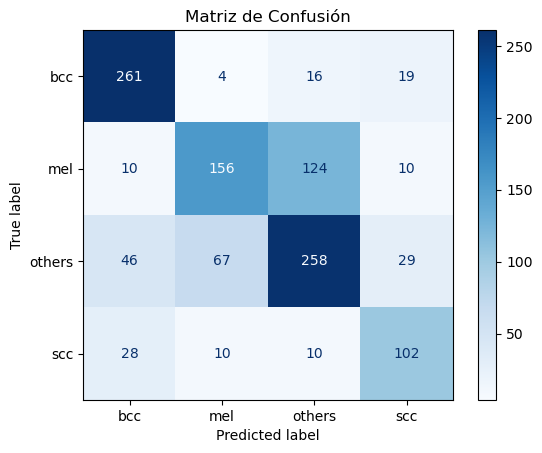

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calcular matriz de confusión
cm = confusion_matrix(labels, predicted_classes)

# Mostrar la matriz de confusión
labels_names = ds['train'].features['label'].names  # Nombres de las clases
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Matriz de Confusión")
plt.show()

In [25]:
from sklearn.metrics import classification_report

print(classification_report(labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       300
           1       0.66      0.52      0.58       300
           2       0.63      0.65      0.64       400
           3       0.64      0.68      0.66       150

    accuracy                           0.68      1150
   macro avg       0.67      0.68      0.67      1150
weighted avg       0.67      0.68      0.67      1150



In [40]:
import os
import torchvision.transforms as T
import json
from tqdm.notebook import tqdm
from PIL import Image

In [32]:
ds = load_dataset("C:/Tesis/DatasetBinario", num_proc=3)
cwd = os.getcwd()

ROOT_DIR = os.path.join(cwd, "C:/Tesis/DatasetBinario/train")

labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg") or file.endswith(".png"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = labels.keys()

Resolving data files:   0%|          | 0/20959 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/761 [00:00<?, ?it/s]

In [33]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitg14")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)
transform_image = T.Compose([
    T.Resize(244),                # Escala el lado más corto a 244 píxeles
    T.CenterCrop(224),            # Recorta una región central de 224x224
    T.ToTensor(),                 # Convierte la imagen a tensor
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliza con mean y std de ImageNet
])

Using cache found in C:\Users\abadd/.cache\torch\hub\facebookresearch_dinov2_main


In [36]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}
    
    with torch.no_grad():
      for i, file in enumerate(tqdm(files)):
        embeddings = dinov2_vits14(load_image(file).to(device))

        all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

In [41]:
embeddings = compute_embeddings(files)

  0%|          | 0/20959 [00:00<?, ?it/s]

KeyboardInterrupt: 